<a href="https://colab.research.google.com/github/sayakpaul/PAWS-TF/blob/main/PAWS_Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Paper reference: https://arxiv.org/pdf/2104.13963.pdf
* Code reference: https://github.com/ayulockin/SwAV-TF/blob/master/initial_notebooks/Building_MultiCropDataset.ipynb

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")

Total training examples: 50000


The two large-crops (global views) are generated with scale (0.75, 1.0),
and the six small-crops (local views) are generated with scale (0.3, 0.75).

In [3]:
BS = 64
SIZE_CROPS = [32, 18]
NUM_CROPS = [2, 6]
GLOBAL_SCALE = [0.75, 1.0] 
LOCAL_SCALE = [0.3, 0.75]
AUTO = tf.data.AUTOTUNE

## Multi-crop augmentation

In [4]:
@tf.function
def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    x = tf.clip_by_value(x, 0, 255)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

@tf.function
def custom_augment(image):        
    # Random flips
    image = tf.image.random_flip_left_right(image)
    
    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.8)
    # Randomly apply grayscale
    image = random_apply(color_drop, image, p=0.2)

    return (image)

@tf.function
def random_resize_crop(image, scale, crop_size):
    # Conditional resizing
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 24
        image = tf.image.resize(image, (image_shape, image_shape))
    # Get the crop size for given scale
    size = tf.random.uniform(shape=(1,), 
                            minval=scale[0]*image_shape, maxval=scale[1]*image_shape, 
                            dtype=tf.float32)
    size = tf.cast(size, tf.int32)[0]
    # Get the crop from the image
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    # Color distortions
    distored_image = custom_augment(crop_resize)
    return distored_image

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)

In [6]:
trainloaders = tuple()
for i, num_crop in enumerate(NUM_CROPS):
    for _ in range(num_crop):
        if SIZE_CROPS[i] == 32:
            scale = GLOBAL_SCALE
        elif SIZE_CROPS[i] == 18:
            scale = LOCAL_SCALE
        
        trainloader = (
            train_ds
            .map(lambda x: random_resize_crop(x, scale, SIZE_CROPS[i]), 
                 num_parallel_calls=AUTO, deterministic=True)
        )
        trainloaders += (trainloader,)

In [7]:
# Zipping 
final_trainloader = tf.data.Dataset.zip(trainloaders)

# Final trainloader
final_trainloader = (
    final_trainloader
    .shuffle(BS * 100)
    .batch(64)
    .prefetch(AUTO)
)

In [8]:
im1, im2, im3, im4, im5, im6, im7, im8 = next(iter(final_trainloader))
print(im1.shape, im2.shape, im3.shape, im4.shape, im5.shape, im6.shape, im7.shape, im8.shape)

(64, 32, 32, 3) (64, 32, 32, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3)


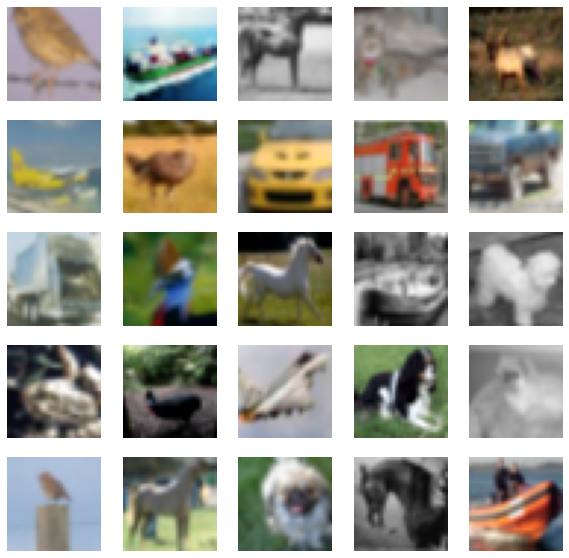

In [9]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im1[n].numpy().astype("int"))
    plt.axis("off")

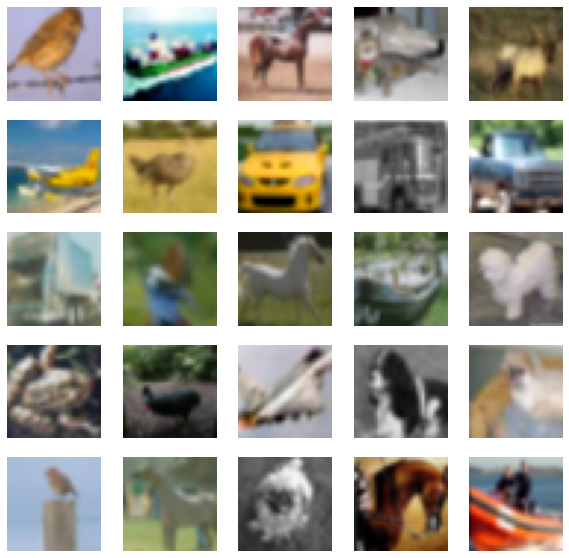

In [10]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im2[n].numpy().astype("int"))
    plt.axis("off")

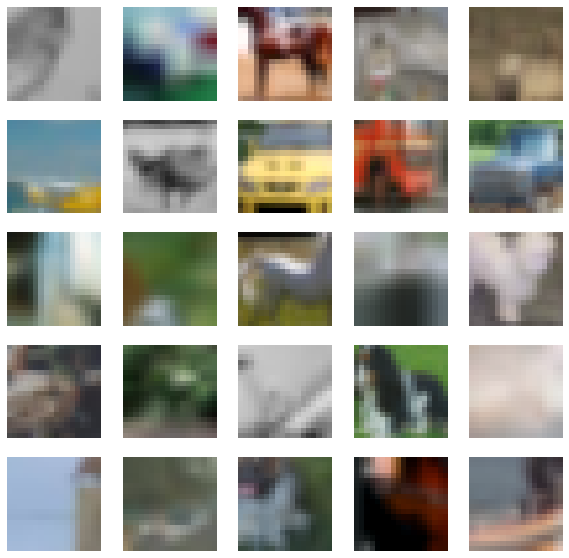

In [11]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im3[n].numpy().astype("int"))
    plt.axis("off")

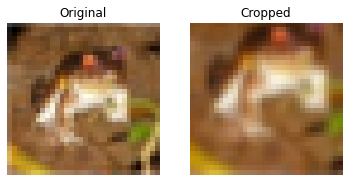

In [16]:
one_image = x_train[0]
cropped_distorted = random_resize_crop(one_image, GLOBAL_SCALE, crop_size=32)

_, ax = plt.subplots(ncols=2, nrows=1)
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(one_image)
ax[1].imshow(cropped_distorted.numpy().astype("int"))
ax[0].set_title("Original")
ax[1].set_title("Cropped")

plt.show()

## Sampling of labeled samples